In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [5]:
# recreate carlsten

In [188]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g        = sp.symbols('a b x g')

In [189]:
f0p0high = p1 / (1-sp.exp(-b)) * sp.integrate(sp.exp(-x), (x, b, sp.oo))
f0p0high

p_1*exp(-b)/(1 - exp(-b))

In [190]:
integrand = p1 * sp.exp(-x) * (sp.exp(-b+x) + a*(1-sp.exp(-b+x)) + (1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)) / (1-sp.exp(-b))
f0p0low = sp.integrate(integrand, (x,0,b))

In [191]:
f0pp0p     = a*(1-a)*p1
f0ppp0pp   = a**2*p1
f1p1       = a*(2-a)*p1
fRestpRest = p1*2*(1-a)*a**2 / ((1-a)*(1-2*a))
fRestpRest

2*a**2*p_1/(1 - 2*a)

In [192]:
full = f0p0low + f0p0high + f0pp0p + f0ppp0pp + f1p1 + fRestpRest
full = sp.simplify(full)
full

Piecewise((-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) - (2*a - 1)*(exp(b) - 1)*(a**2*g - 2*a*g - a*(a - 2) - a*(a - 1) + 2*a + g))/((2*a - 1)*(exp(b) - 1)), (b > 0) | (b < 0)), (-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) + (2*a - 1)*(a*(1 - exp(b))*(3 - a) - b*(a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b)))/((2*a - 1)*(exp(b) - 1)), True))

In [193]:
p0pp  = a*p1
p0p   = (1-a)*p1
p0    = p1 / (a*(1-sp.exp(-b)))
pRest = (1-a)*a/((1-a)*(1-2*a)) * p1

In [194]:
p1solved = sp.solve(sp.Eq(p0 + p0p + p0pp + p1 + pRest, 1), p1)[0]
p1solved

a*(2*a*exp(b) - 2*a - exp(b) + 1)/(3*a**2*exp(b) - 3*a**2 + 2*a - exp(b))

In [195]:
final = sp.simplify(full.evalf(subs={p1:p1solved}))
final

Piecewise((a*(-2.0*a**2*(exp(b) - 1) - (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(exp(b) - 1.0)*(a**2*g - 2.0*a*g - a*(a - 2.0) - a*(a - 1.0) + 2.0*a + g))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), (b > 0) | (b < 0)), (-a*(2.0*a**2*(exp(b) - 1) + (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(a*(a - 3.0)*(exp(b) - 1.0) - b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g)*exp(b)))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), True))

In [196]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

<function _lambdifygenerated(a, b, g)>

In [254]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [255]:
alpha  = 0.3
betas  = np.arange(0.1, 10, 0.01)
gammas = [0., 0.5, 1.]

resMines = []
resTheir = []
for g in gammas:
    resMines.append(finalLambda(alpha, betas, g))
    resTheir.append(Carlsten(alpha, betas, g))

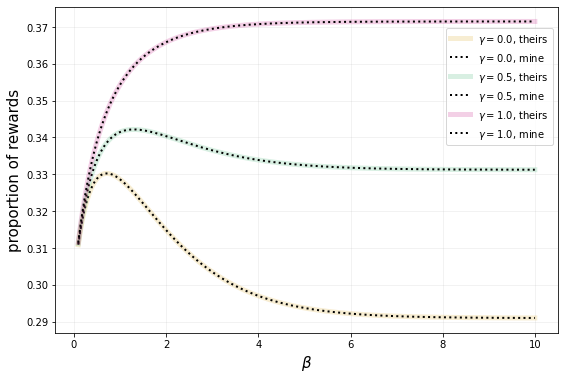

In [258]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    ax.plot(betas, resTheir[i], color=colors[i], alpha=0.2,
            label='$\gamma={:0.1f}$, theirs'.format(gammas[i]), 
            linestyle='-', linewidth=5)
    ax.plot(betas, resMines[i], color='k', alpha=1, 
            label='$\gamma={:0.1f}$, mine'.format(gammas[i]),
            linestyle='dotted', linewidth=2)


ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [208]:
(resTheir[0] -  resMines[0]).min(), (resTheir[0] -  resMines[0]).max()

(-4.996003610813204e-16, 4.440892098500626e-16)

# Now w/ SQRT

In [209]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g        = sp.symbols('a b x g')

In [210]:
f0p0high = p1 / (1-sp.exp(-(b**2))) * sp.integrate(sp.exp(-(x**2)), (x, b, sp.oo))
f0p0high

p_1*(-sqrt(pi)*erf(b)/2 + sqrt(pi)/2)/(1 - exp(-b**2))

In [262]:
sp.integrate(sp.exp(-(x**2)), (x, b, sp.oo))

-sqrt(pi)*erf(b)/2 + sqrt(pi)/2

In [249]:
sp.expand((b+x)**2)

b**2 + 2*b*x + x**2

In [253]:
integrand = p1 * sp.exp(-(x**2)) * (sp.exp(-(b**2-2*b*x+x**2)) + a*(1-sp.exp(-(b**2-2*b*x+x**2))) + (1-a)*(1-sp.exp(-(b**2-2*b*x+x**2)))*(a+(1-a)*g)) / (1-sp.exp(-(b**2)))
# integrand
f0p0low = sp.integrate(integrand, (x,0,b))

KeyboardInterrupt: 

In [243]:
f0p0low

p_1*(Integral(2*a, b) + Integral(-a**2, b) + Integral(g, b) + Integral(-2*a*g, b) + Integral(a**2*g, b) + Integral(exp(b)*exp(-b**2), b) + Integral(-2*a*exp(b)*exp(-b**2), b) + Integral(a**2*exp(b)*exp(-b**2), b) + Integral(-g*exp(b)*exp(-b**2), b) + Integral(2*a*g*exp(b)*exp(-b**2), b) + Integral(-a**2*g*exp(b)*exp(-b**2), b))/(exp(b**2) - 1) - p_1*(Integral(exp(x)*exp(-x**2), (x, 0)) + Integral(2*a*exp(b**2)*exp(-x**2), (x, 0)) + Integral(-2*a*exp(x)*exp(-x**2), (x, 0)) + Integral(-a**2*exp(b**2)*exp(-x**2), (x, 0)) + Integral(a**2*exp(x)*exp(-x**2), (x, 0)) + Integral(g*exp(b**2)*exp(-x**2), (x, 0)) + Integral(-g*exp(x)*exp(-x**2), (x, 0)) + Integral(-2*a*g*exp(b**2)*exp(-x**2), (x, 0)) + Integral(2*a*g*exp(x)*exp(-x**2), (x, 0)) + Integral(a**2*g*exp(b**2)*exp(-x**2), (x, 0)) + Integral(-a**2*g*exp(x)*exp(-x**2), (x, 0)))/(exp(b**2) - 1)

In [230]:
f0pp0p     = a*(1-a)*p1
f0ppp0pp   = a**2*p1
f1p1       = a*(2-a)*p1
fRestpRest = p1*2*(1-a)*a**2 / ((1-a)*(1-2*a))
fRestpRest

2*a**2*p_1/(1 - 2*a)

In [231]:
full = f0p0low + f0p0high + f0pp0p + f0ppp0pp + f1p1 + fRestpRest
full = sp.simplify(full)
full

-p_1*(4*a**2*(exp(b**2) - 1) + 2*a*(a - 3)*(2*a - 1)*(exp(b**2) - 1) + sqrt(pi)*(2*a - 1)*(erf(b) - 1)*exp(b**2) - 2*(2*a - 1)*(a**2*b*g - a**2*b - a**2*g*Integral(exp(b)*exp(-b**2), b) + a**2*g*Integral(exp(x)*exp(-x**2), (x, 0)) + a**2*Integral(exp(b)*exp(-b**2), b) - a**2*Integral(exp(x)*exp(-x**2), (x, 0)) - 2*a*b*g + 2*a*b + 2*a*g*Integral(exp(b)*exp(-b**2), b) - 2*a*g*Integral(exp(x)*exp(-x**2), (x, 0)) - 2*a*Integral(exp(b)*exp(-b**2), b) + 2*a*Integral(exp(x)*exp(-x**2), (x, 0)) + b*g - g*Integral(exp(b)*exp(-b**2), b) + g*Integral(exp(x)*exp(-x**2), (x, 0)) + Integral(exp(b)*exp(-b**2), b) - Integral(exp(x)*exp(-x**2), (x, 0))))/(2*(2*a - 1)*(exp(b**2) - 1))

In [233]:
p0pp  = a*p1
p0p   = (1-a)*p1
p0    = p1 / (a*(1-sp.exp(-(b**2))))
pRest = (1-a)*a/((1-a)*(1-2*a)) * p1

In [234]:
p1solved = sp.solve(sp.Eq(p0 + p0p + p0pp + p1 + pRest, 1), p1)[0]
p1solved

a*(2*a*exp(b**2) - 2*a - exp(b**2) + 1)/(3*a**2*exp(b**2) - 3*a**2 + 2*a - exp(b**2))

In [235]:
final = sp.simplify(full.evalf(subs={p1:p1solved}))
final

0.5*a*(2.0*a*exp(b**2) - 2.0*a - exp(b**2) + 1.0)*(-4.0*a**2*(exp(b**2) - 1) - 2.0*a*(a - 3.0)*(2.0*a - 1.0)*(exp(b**2) - 1.0) - 1.77245385090552*(2.0*a - 1.0)*(erf(b) - 1.0)*exp(b**2) + 2.0*(2.0*a - 1.0)*(a**2*b*g - a**2*b - a**2*g*Integral(exp(b)*exp(-b**2), b) + a**2*g*Integral(exp(x)*exp(-x**2), (x, 0)) + a**2*Integral(exp(b)*exp(-b**2), b) - a**2*Integral(exp(x)*exp(-x**2), (x, 0)) - 2.0*a*b*g + 2.0*a*b + 2.0*a*g*Integral(exp(b)*exp(-b**2), b) - 2.0*a*g*Integral(exp(x)*exp(-x**2), (x, 0)) - 2.0*a*Integral(exp(b)*exp(-b**2), b) + 2.0*a*Integral(exp(x)*exp(-x**2), (x, 0)) + b*g - g*Integral(exp(b)*exp(-b**2), b) + g*Integral(exp(x)*exp(-x**2), (x, 0)) + Integral(exp(b)*exp(-b**2), b) - Integral(exp(x)*exp(-x**2), (x, 0))))/((2.0*a - 1.0)*(exp(b**2) - 1.0)*(3.0*a**2*exp(b**2) - 3.0*a**2 + 2.0*a - exp(b**2)))

In [239]:
final.evalf(subs={a:0.3, b:1., g:0.5})

0.0177713759476019*Integral(exp(b)*exp(-b**2), (b, 1.0)) - 0.0177713759476019*Integral(exp(x)*exp(-x**2), (x, 0)) + 0.239294926997411

In [236]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

NotImplementedError: Only definite integrals are supported

In [187]:
front = sp.exp(-b) - a*sp.exp(-b) - (1-a)*(a+(1-a)*g)*sp.exp(-b)
integrand = a*sp.exp(-x) + (1-a)*(a + (1-a)*g)*sp.exp(-x)
integrand

a*exp(-x) + (1 - a)*(a + g*(1 - a))*exp(-x)

In [144]:
sp.integrate(integrand, (x, 0, b))

a**2*g - a**2 - 2*a*g + 2*a + g + (-a**2*g + a**2 + 2*a*g - 2*a - g)*exp(-b)

In [150]:
sp.integrate(sp.exp(-x), (x, 0, b))

1 - exp(-b)

In [130]:
f0p0low = p1 / (1-sp.exp(-b)) * (front + sp.integrate(integrand, (x, 0, b)))
f0p0low

p_1*(a**2*g - a**2 - 2*a*g + 2*a - a*exp(-b) + g - (1 - a)*(a + g*(1 - a))*exp(-b) + (-a**2*g + a**2 + 2*a*g - 2*a - g)*exp(-b) + exp(-b))/(1 - exp(-b))

In [142]:
theirFront = p1 * b * sp.exp(-b) * (1-a-(1-a)*(a+(1-a)*g)) / (1-sp.exp(-b))
theirFront

b*p_1*(-a - (1 - a)*(a + g*(1 - a)) + 1)*exp(-b)/(1 - exp(-b))

In [140]:
myFront = p1 * front / (1-sp.exp(-b))
myFront

p_1*(-a*exp(-b) - (1 - a)*(a + g*(1 - a))*exp(-b) + exp(-b))/(1 - exp(-b))

In [131]:
num = p1 * (b * sp.exp(-b) * (1-a) * (1-a-(1-a)*g) + (1-sp.exp(-b))*(a+(1-a)*(a+(1-a)*g)))
den = 1-sp.exp(-b)
theirPLow = num / den
theirPLow

p_1*(b*(1 - a)*(-a - g*(1 - a) + 1)*exp(-b) + (1 - exp(-b))*(a + (1 - a)*(a + g*(1 - a))))/(1 - exp(-b))

In [159]:
f0p0low.evalf(subs={a:0.3, b:2, g:0.24}), theirPLow.evalf(subs={a:0.3, b:2, g:0.24})

(0.685887170159976*p_1, 0.744174340319951*p_1)

In [166]:
f0p0low2_int.evalf(subs={a:0.3, b:2.7, g:0.24}), theirPLow.evalf(subs={a:0.3, b:2.7, g:0.24})

(0.700042322368389*p_1, 0.700042322368389*p_1)